In [1]:
import ipyplot

import rawpy 
import cv2
import numpy as np

import os
import os.path as op

data_dir = op.join("..", "data")
img_name = "DSC01088"
raw_fp = op.join(data_dir, img_name+".ARW")
jpg_fp = op.join(data_dir, img_name+".JPG")

assert op.exists(raw_fp)
assert op.exists(jpg_fp)

## Functions

In [2]:
def raw_reader(fp, bit_depth):
    _img = rawpy.imread(fp)
    img = _img.raw_image.copy()
    img = np.expand_dims(img,axis=2)
    black_level = _img.black_level_per_channel[0] # assume all black level is the same
    new_img = (np.minimum(np.maximum(img.astype(np.float32) - black_level , 0) + black_level, 2**bit_depth - 1) - black_level) / ( (2 ** bit_depth - 1))
    return new_img

def raw_packer(img):
    H = img.shape[0]
    W = img.shape[1]
    return np.concatenate((img[0:H:2, 0:W:2, :],# R
                img[0:H:2, 1:W:2, :],           # GR
                img[1:H:2, 0:W:2, :],           # GB
                img[1:H:2, 1:W:2, :]), axis=2)  # B

def raw_reader_postprocessor(fp):
    with rawpy.imread(fp) as f:
        rgb = f.postprocess(gamma=(1,1), no_auto_bright=True, output_bps=16)
    return rgb

In [3]:
jpg = cv2.imread(jpg_fp)[:,:,::-1]
raw_packed = np.array(raw_packer(raw_reader(raw_fp, 12))*255, dtype=np.uint8)
raw_postprocessed = np.array(raw_reader_postprocessor(raw_fp)/2**16*255, dtype=np.uint8)

rh, rw, rc = raw_packed.shape
rgb_mask = np.ones_like(raw_packed, dtype=np.bool)
rgb_mask[:,:,1]=False
raw_packed = raw_packed[rgb_mask].reshape(rh, rw, 3)

/home/phd/09/igor/miniconda3/envs/mmdet/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [4]:
imgs = [jpg, raw_packed, raw_postprocessed]
img_names = ["jpg", "packed raw (4->3 ch.)", "rawpy jpg"]

## Image sizes

In [5]:
for img, img_name in zip(imgs, img_names):
    print(img_name, img.dtype, img.shape)

jpg uint8 (3648, 5472, 3)
packed raw (4->3 ch.) uint8 (1836, 2752, 3)
rawpy jpg uint8 (3672, 5496, 3)


/home/phd/09/igor/miniconda3/envs/mmdet/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)



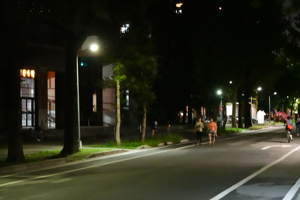
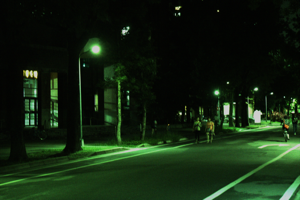
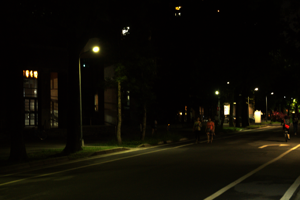


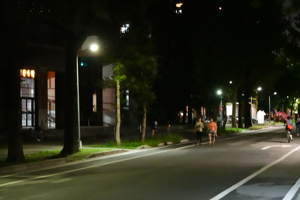
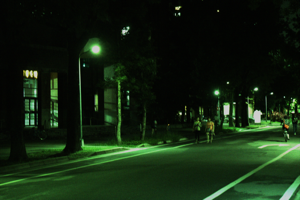
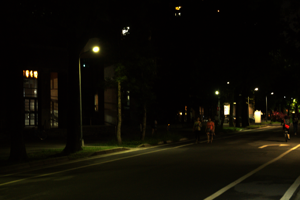

In [6]:
ipyplot.plot_images(imgs,img_width=300,max_images=3)

Result: (1836, 2752) * 2 = (3672, 5504) =/= (3672, 5496)